# Deep Learning Bootcamp November 2017, GPU Computing for Data Scientists

<img src="../images/bcamp.png" align="center">

## 18  PyTorch NUMER.AI  Deep Learning Binary Classification using BCELoss 

Web: https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/events/241762893/

Notebooks: <a href="https://github.com/QuantScientist/Data-Science-PyCUDA-GPU"> On GitHub</a>

*Shlomo Kashani*

<img src="../images/pt.jpg" width="35%" align="center">


# What consists a Numerai competition?
- Numerai provides payments based on the number of correctly predictted labels (LOGG_LOSS) in a data-set which changes every week.

- Two data-sets are provided: numerai_training_data.csv and numerai_tournament_data.csv

# Criteria 
- On top of LOG_LOSS, they also measure:
* Consistency
* Originality	
* Concordance 


# PyTorch and Numerai

- This tutorial was written in order to demonstrate a **fully working** example of a PyTorch NN on a real world use case, namely a Binary Classification problem on the NumerAI data set. If you are interested in the sk-learn version of this problem please refer to: https://github.com/QuantScientist/deep-ml-meetups/tree/master/hacking-kaggle/python/numer-ai 

- For the scientific foundation behind Binary Classification and Logistic Regression, refer to: https://github.com/QuantScientist/Deep-Learning-Boot-Camp/tree/master/Data-Science-Interviews-Book

- Every step, from reading the CSV into numpy arrays, converting to GPU based tensors, training and validation, are meant to aid newcomers in their first steps in PyTorch. 

- Additionally, commonly used Kaggle metrics such as ROC_AUC and LOG_LOSS are logged and plotted both for the training set as well as for the validation set. 

- Thus, the NN architecture is naive and by no means **optimized**. Hopefully, I will improve it over time and I am working on a second CNN based version of the same problem. 



## Data
- Download from https://numer.ai/leaderboard


<img src="../images/numerai-logo.png" width="35%" align="center">


# PyTorch Imports


In [1]:
# !pip install pycuda
%reset -f
# %%timeit

import torch
from torch.autograd import Variable
import numpy as np
import pandas
import numpy as np
import pandas as pd
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc
from sklearn.cross_validation import StratifiedKFold, ShuffleSplit, cross_val_score, train_test_split
import logging
import numpy
import numpy as np
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MultiLabelBinarizer
import time
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import scipy
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = (6, 6)      # setting default size of plots
import tensorflow as tf 
print("tensorflow:" + tf.__version__)
!set "KERAS_BACKEND=tensorflow"
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')

# !pip install http://download.pytorch.org/whl/cu75/torch-0.2.0.post1-cp27-cp27mu-manylinux1_x86_64.whl
# !pip install torchvision 
# ! pip install cv2
# import cv2

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)

handler=logging.basicConfig(level=logging.INFO)
lgr = logging.getLogger(__name__)
%matplotlib inline

# !pip install psutil
import psutil
def cpuStats():
        print(sys.version)
        print(psutil.cpu_percent())
        print(psutil.virtual_memory())  # physical memory usage
        pid = os.getpid()
        py = psutil.Process(pid)
        memoryUse = py.memory_info()[0] / 2. ** 30  # memory use in GB...I think
        print('memory GB:', memoryUse)

cpuStats()

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


tensorflow:1.2.1
__Python VERSION: 2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
__pyTorch VERSION: 0.2.0+42448cf
__CUDA VERSION
__CUDNN VERSION: None
__Number CUDA Devices: 0
__Devices
OS:  linux2
Python:  2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
PyTorch:  0.2.0+42448cf
Numpy:  1.13.1
2.7.12 (default, Nov 19 2016, 06:48:10) 
[GCC 5.4.0 20160609]
0.0
svmem(total=67469099008, available=58820988928, percent=12.8, used=7999918080, free=54381559808, active=10602860544, inactive=1363619840, buffers=1100660736, cached=3986960384, shared=99926016)
memory GB: 0.218952178955


#  CUDA

In [2]:
# %%timeit
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

lgr.info("USE CUDA=" + str (use_cuda))

# ! watch -n 0.1 'ps f -o user,pgrp,pid,pcpu,pmem,start,time,command -p `lsof -n -w -t /dev/nvidia*`'
# sudo apt-get install dstat #install dstat
# sudo pip install nvidia-ml-py #install Python NVIDIA Management Library
# wget https://raw.githubusercontent.com/datumbox/dstat/master/plugins/dstat_nvidia_gpu.py
# sudo mv dstat_nvidia_gpu.py /usr/share/dstat/ #move file to the plugins directory of dstat

INFO:__main__:USE CUDA=False


#  Global params

In [3]:
# NN params
PIN_MEMORY=use_cuda # True IF CUDA

# Data params
TARGET_VAR= 'target'
TOURNAMENT_DATA_CSV = 'numerai_tournament_data.csv'
TRAINING_DATA_CSV = 'numerai_training_data.csv'
BASE_FOLDER = 'numerai/'

# fix seed
seed=17*19
np.random.seed(seed)
# torch.manual_seed(seed)
if use_cuda:
    torch.cuda.manual_seed(seed)

#  Load a CSV file for Binary classification (numpy)

As mentioned, NumerAI provided **numerai_training_data.csv** and **numerai_tournament_data.csv.**

- Training_data.csv is labeled
- Numerai_tournament_data.csv has lebles for the **validation set** and no labels for the **test set**. See belo how I seperate them.

In [4]:
# %%timeit
df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
df_train.head(5)

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,target
0,72774,era1,train,0.48937,0.56969,0.59150,0.46432,0.42291,0.49616,0.53542,...,0.42195,0.62651,0.51604,0.42938,0.56744,0.60008,0.46966,0.50322,0.42803,1
1,140123,era1,train,0.57142,0.43408,0.58771,0.44570,0.41471,0.49137,0.52791,...,0.46301,0.55103,0.39053,0.48856,0.54305,0.59213,0.44935,0.56685,0.59645,1
2,46882,era1,train,0.75694,0.59942,0.36154,0.65571,0.60520,0.45317,0.49847,...,0.68057,0.43763,0.46322,0.63211,0.32947,0.35632,0.56316,0.33888,0.40120,0
3,20833,era1,train,0.46059,0.50856,0.64215,0.41382,0.39550,0.49282,0.54697,...,0.38108,0.65446,0.54926,0.36297,0.61482,0.64292,0.52910,0.53582,0.47027,0
4,5381,era1,train,0.61195,0.66684,0.45877,0.56730,0.51889,0.41257,0.56030,...,0.54803,0.59120,0.58160,0.51828,0.43870,0.47011,0.56007,0.36374,0.31552,1


#  Feature enrichement
- This would be usually not required when using NN's; it is here for demonstration purposes.  

In [5]:
# def genBasicFeatures(inDF):
#     print('Generating basic features ...')
#     df_copy=inDF.copy(deep=True)
#     magicNumber=21
#     feature_cols = list(inDF.columns)

#     inDF['x_mean'] = np.mean(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_median'] = np.median(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_std'] = np.std(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_skew'] = scipy.stats.skew(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_kurt'] = scipy.stats.kurtosis(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_var'] = np.var(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_max'] = np.max(df_copy.ix[:, 0:magicNumber], axis=1)
#     inDF['x_min'] = np.min(df_copy.ix[:, 0:magicNumber], axis=1)    

#     return inDF

def addPolyFeatures(inDF, deg=2):
    print('Generating poly features ...')
    df_copy=inDF.copy(deep=True)
    poly=PolynomialFeatures(degree=deg)
    p_testX = poly.fit(df_copy)
    # AttributeError: 'PolynomialFeatures' object has no attribute 'get_feature_names'
    target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(df_copy.columns,p) for p in poly.powers_]]
    df_copy = pd.DataFrame(p_testX.transform(df_copy),columns=target_feature_names)
        
    return df_copy

#  Train / Validation / Test Split
- Numerai provides a data set that is allready split into train, validation and test sets. 

In [6]:
# Train, Validation, Test Split
def loadDataSplit():
    df_train = pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV)
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    df_test_valid = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)

    answers_1_SINGLE = df_train[TARGET_VAR]
    df_train.drop(TARGET_VAR, axis=1,inplace=True)
    df_train.drop('id', axis=1,inplace=True)
    df_train.drop('era', axis=1,inplace=True)
    df_train.drop('data_type', axis=1,inplace=True)    
    
    # Add polynomial features    
#     df_train=genBasicFeatures(df_train)
#     df_train = addPolyFeatures(df_train)

    df_train.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=False,  index = False)    
    df_train= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + 'clean.csv', header=None, dtype=np.float32)    
    df_train = pd.concat([df_train, answers_1_SINGLE], axis=1)
    feature_cols = list(df_train.columns[:-1])
#     print (feature_cols)
    target_col = df_train.columns[-1]
    trainX, trainY = df_train[feature_cols], df_train[target_col]
    
    
    # TOURNAMENT_DATA_CSV has both validation and test data provided by NumerAI
    # Validation set
    df_validation_set=df_test_valid.loc[df_test_valid['data_type'] == 'validation'] 
    df_validation_set=df_validation_set.copy(deep=True)
    answers_1_SINGLE_validation = df_validation_set[TARGET_VAR]
    df_validation_set.drop(TARGET_VAR, axis=1,inplace=True)    
    df_validation_set.drop('id', axis=1,inplace=True)
    df_validation_set.drop('era', axis=1,inplace=True)
    df_validation_set.drop('data_type', axis=1,inplace=True)
    
   # Add polynomial features    
#     df_validation_set=genBasicFeatures(df_validation_set)
#     df_validation_set = addPolyFeatures(df_validation_set)
    
    df_validation_set.to_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=False,  index = False)    
    df_validation_set= pd.read_csv(BASE_FOLDER + TRAINING_DATA_CSV + '-validation-clean.csv', header=None, dtype=np.float32)    
    df_validation_set = pd.concat([df_validation_set, answers_1_SINGLE_validation], axis=1)
    feature_cols = list(df_validation_set.columns[:-1])

    target_col = df_validation_set.columns[-1]
    valX, valY = df_validation_set[feature_cols], df_validation_set[target_col]
                            
    # Test set for submission (not labeled)    
    df_test_set = pd.read_csv(BASE_FOLDER + TOURNAMENT_DATA_CSV)
#     df_test_set=df_test_set.loc[df_test_valid['data_type'] == 'live'] 
    df_test_set=df_test_set.copy(deep=True)
    df_test_set.drop(TARGET_VAR, axis=1,inplace=True)
    tid_1_SINGLE = df_test_set['id']
    df_test_set.drop('id', axis=1,inplace=True)
    df_test_set.drop('era', axis=1,inplace=True)
    df_test_set.drop('data_type', axis=1,inplace=True)   
    
    # Add polynomial features    
#     df_test_set=genBasicFeatures(df_test_set)
#     df_test_set = addPolyFeatures(df_test_set)
   
    
    feature_cols = list(df_test_set.columns) # must be run here, we dont want the ID    
#     print (feature_cols)
    df_test_set = pd.concat([tid_1_SINGLE, df_test_set], axis=1)            
    testX = df_test_set[feature_cols].values
        
    return trainX, trainY, valX, valY, testX, df_test_set

In [7]:
# %%timeit
trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()
# # Number of features for the input layer
N_FEATURES=trainX.shape[1]
print (trainX.shape)
print (trainY.shape)
print (valX.shape)
print (valY.shape)
print (testX.shape)
print (df_test_set.shape)

(108405, 21)
(108405,)
(16686, 21)
(16686,)
(45668, 21)
(45668, 22)


#  Create PyTorch GPU tensors from numpy arrays

- Note how we transfrom the np arrays

In [8]:
# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def XnumpyToTensor(x_data_np):
    x_data_np = np.array(x_data_np.values, dtype=np.float32)        
    print(x_data_np.shape)
    print(type(x_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")    
        X_tensor = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        lgr.info ("Using the CPU")
        X_tensor = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
    
    print(type(X_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(x_data_np.shape)
    print(type(x_data_np))    
    return X_tensor


# Convert the np arrays into the correct dimention and type
# Note that BCEloss requires Float in X as well as in y
def YnumpyToTensor(y_data_np):    
    y_data_np=y_data_np.reshape((y_data_np.shape[0],1)) # Must be reshaped for PyTorch!
    print(y_data_np.shape)
    print(type(y_data_np))

    if use_cuda:
        lgr.info ("Using the GPU")            
    #     Y = Variable(torch.from_numpy(y_data_np).type(torch.LongTensor).cuda())
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor).cuda()  # BCEloss requires Float        
    else:
        lgr.info ("Using the CPU")        
    #     Y = Variable(torch.squeeze (torch.from_numpy(y_data_np).type(torch.LongTensor)))  #         
        Y_tensor = Variable(torch.from_numpy(y_data_np)).type(torch.FloatTensor)  # BCEloss requires Float        

    print(type(Y_tensor.data)) # should be 'torch.cuda.FloatTensor'
    print(y_data_np.shape)
    print(type(y_data_np))    
    return Y_tensor

# The NN model

### MLP model
- A multilayer perceptron is a logistic regressor where instead of feeding the input to the logistic regression you insert a intermediate layer, called the hidden layer, that has a nonlinear activation function (usually tanh or sigmoid) . One can use many such hidden layers making the architecture deep.

- Here we define a simple MLP structure. We map the input feature vector to a higher space, then later gradually decrease the dimension, and in the end into a 1-dimension space. Because we are calculating the probability of each genre independently, after the final layer we need to use a sigmoid layer. 

###  Initial weights selection

- There are many ways to select the initial weights to a neural network architecture. A common initialization scheme is random initialization, which sets the biases and weights of all the nodes in each hidden layer randomly.

- Before starting the training process, an initial value is assigned to each variable. This is done by pure randomness, using for example a uniform or Gaussian distribution. But if we start with weights that are too small, the signal could decrease so much that it is too small to be useful. On the other side, when the parameters are initialized with high values, the signal can end up to explode while propagating through the network.

- In consequence, a good initialization can have a radical effect on how fast the network will learn useful patterns.For this purpose, some best practices have been developed. One famous example used is **Xavier initialization**. Its formulation is based on the number of input and output neurons and uses sampling from a uniform distribution with zero mean and all biases set to zero.

- In effect (according to theory) initializing the weights of the network to values that would be closer to the optimal, and therefore require less epochs to train.

### References: 
* **`nninit.xavier_uniform(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf), using a uniform distribution.
* **`nninit.xavier_normal(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Understanding the difficulty of training deep feedforward neural networks" - Glorot, X. and Bengio, Y.](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf), using a normal distribution.
* **`nninit.kaiming_uniform(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification" - He, K. et al.](https://arxiv.org/abs/1502.01852) using a uniform distribution.
* **`nninit.kaiming_normal(tensor, gain=1)`** - Fills `tensor` with values according to the method described in ["Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification" - He, K. et al.]


In [20]:
# p is the probability of being dropped in PyTorch
dropout = torch.nn.Dropout(p=1 - 0.90)
LR = 0.005
MOMENTUM= 0.9

# class Net2(nn.Module):
#     def __init__(self, n_feature, n_hidden, n_output,initKernel='uniform'):
#         super(Net2, self).__init__()
#         self.dis = nn.Sequential(
#             nn.Linear(n_feature, n_hidden),
#             dropout,
#             nn.LeakyReLU(0.1),
                                    
#             nn.Linear(n_hidden, int(n_hidden /2)),
#             dropout,
#             nn.LeakyReLU(0.1),
            
#             nn.Linear(int(n_hidden /2), int(n_hidden /4)),
#             dropout,
#             nn.LeakyReLU(0.1),
            
#             nn.Linear(int(n_hidden /4), 1),            
#             nn.Sigmoid()
#         )        
#     def forward(self, x):
#         x = self.dis(x)
#         return x

# net = Net(n_feature=N_FEATURES, n_hidden=1024, n_output=1)   # define the network
# net = Net2(n_feature=N_FEATURES, n_hidden=512, n_output=1)   # define the network


hiddenLayer1Size=128
hiddenLayer2Size=int(hiddenLayer1Size/64)
hiddenLayer3Size=int(hiddenLayer1Size/32)
hiddenLayer4Size=int(hiddenLayer1Size/16)
hiddenLayer5Size=int(hiddenLayer1Size/8)
hiddenLayer6Size=int(hiddenLayer1Size/4)

linear1=torch.nn.Linear(N_FEATURES, hiddenLayer1Size, bias=True) 
torch.nn.init.xavier_uniform(linear1.weight)

linear2=torch.nn.Linear(hiddenLayer1Size, hiddenLayer2Size)
torch.nn.init.xavier_uniform(linear2.weight)

linear3=torch.nn.Linear(hiddenLayer2Size, hiddenLayer3Size)
torch.nn.init.xavier_uniform(linear3.weight)

linear4=torch.nn.Linear(hiddenLayer3Size, hiddenLayer4Size)
torch.nn.init.xavier_uniform(linear4.weight)

linear5=torch.nn.Linear(hiddenLayer4Size, hiddenLayer5Size)
torch.nn.init.xavier_uniform(linear5.weight)

linear6=torch.nn.Linear(hiddenLayer5Size, hiddenLayer6Size)
torch.nn.init.xavier_uniform(linear6.weight)

linear7=torch.nn.Linear(hiddenLayer6Size, 1)
torch.nn.init.xavier_uniform(linear7.weight)

sigmoid = torch.nn.Sigmoid()
tanh=torch.nn.Tanh()
relu=torch.nn.LeakyReLU()

net = torch.nn.Sequential(linear1,dropout,tanh,nn.BatchNorm1d(hiddenLayer1Size),
                          linear2,dropout,tanh,
                          linear3,dropout,tanh,
                          linear4,dropout,tanh,
                          linear5,dropout,tanh,
                          linear6,dropout,tanh,
                          linear7,sigmoid
                          )


lgr.info(net)  # net architecture

INFO:__main__:Sequential (
  (0): Linear (21 -> 128)
  (1): Dropout (p = 0.1)
  (2): Sigmoid ()
  (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True)
  (4): Linear (128 -> 2)
  (5): Dropout (p = 0.1)
  (6): Sigmoid ()
  (7): Linear (2 -> 4)
  (8): Dropout (p = 0.1)
  (9): Sigmoid ()
  (10): Linear (4 -> 8)
  (11): Dropout (p = 0.1)
  (12): Sigmoid ()
  (13): Linear (8 -> 16)
  (14): Dropout (p = 0.1)
  (15): Sigmoid ()
  (16): Linear (16 -> 32)
  (17): Dropout (p = 0.1)
  (18): Sigmoid ()
  (19): Linear (32 -> 1)
  (20): Sigmoid ()
)


## Print the full net architecture

In [21]:
# Taken from https://stackoverflow.com/questions/42480111/model-summary-in-pytorch/42616812
from torch.nn.modules.module import _addindent
import torch
import numpy as np
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

lgr.info(torch_summarize(net))

INFO:__main__:Sequential (
  (0): Linear (21 -> 128), weights=((128L, 21L), (128L,)), parameters=2816
  (1): Dropout (p = 0.1), weights=(), parameters=0
  (2): Sigmoid (), weights=(), parameters=0
  (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True), weights=((128L,), (128L,)), parameters=256
  (4): Linear (128 -> 2), weights=((2L, 128L), (2L,)), parameters=258
  (5): Dropout (p = 0.1), weights=(), parameters=0
  (6): Sigmoid (), weights=(), parameters=0
  (7): Linear (2 -> 4), weights=((4L, 2L), (4L,)), parameters=12
  (8): Dropout (p = 0.1), weights=(), parameters=0
  (9): Sigmoid (), weights=(), parameters=0
  (10): Linear (4 -> 8), weights=((8L, 4L), (8L,)), parameters=40
  (11): Dropout (p = 0.1), weights=(), parameters=0
  (12): Sigmoid (), weights=(), parameters=0
  (13): Linear (8 -> 16), weights=((16L, 8L), (16L,)), parameters=144
  (14): Dropout (p = 0.1), weights=(), parameters=0
  (15): Sigmoid (), weights=(), parameters=0
  (16): Linear (16 -> 32), weights=((32L, 

#  Loss and Optimizer

###  BCELoss
- In addition, we will calculate the binary cross entropy loss (BCELoss). Luckily we have one loss function already present. For details please checkout http://pytorch.org/docs/master/nn.html. 

- ** NOTE this BCELoss may not be numerical stable, although it's fine during my training process.**

### Optimization

- if return F.log_softmax(x) then loss = F.nll_loss(output, target) (MNIST)
- print(nn.BCEWithLogitsLoss()(o, t)) is equivalent to print(nn.BCELoss()(sigmoid(o), t))

In [22]:
# ! pip install sympy
import sympy as sp
sp.interactive.printing.init_printing(use_latex=True)
from IPython.display import display, Math, Latex
maths = lambda s: display(Math(s))
latex = lambda s: display(Latex(s))

#the loss function is as follows:
maths("\mathbf{Loss Function:} J(x, z) = -\sum_k^d[x_k \log z_k + (1-x_k)log(1-z_k)]")

<IPython.core.display.Math object>

In [23]:
# optimizer = torch.optim.SGD(net.parameters(), lr=0.02)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=5e-4)
#L2 regularization can easily be added to the entire model via the optimizer
optimizer = torch.optim.Adam(net.parameters(), lr=LR,weight_decay=5e-4) #  L2 regularization

loss_func=torch.nn.BCELoss() # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
# http://andersonjo.github.io/artificial-intelligence/2017/01/07/Cost-Functions/

if use_cuda:
    lgr.info ("Using the GPU")    
    net.cuda()
    loss_func.cuda()
#     cudnn.benchmark = True

lgr.info (optimizer)
lgr.info (loss_func)

INFO:__main__:<torch.optim.adam.Adam object at 0x7f3145279fd0>
INFO:__main__:BCELoss (
)


#  Training in batches  + Measuring the performance of the deep learning model

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(108405, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(108405, 21)
<type 'numpy.ndarray'>
(108405, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(108405, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
0 [ 0.71060389]
ACC=0.0, LOG_LOSS=0.69867899879, ROC_AUC=0.497980599888 
10 [ 0.69343209]
ACC=0.0, LOG_LOSS=0.694105538878, ROC_AUC=0.497922154782 
20 [ 0.6936968]
ACC=0.0, LOG_LOSS=0.694118933489, ROC_AUC=0.49802595059 
30 [ 0.69372934]
ACC=0.0, LOG_LOSS=0.693820688951, ROC_AUC=0.497283215447 
40 [ 0.69353294]
ACC=0.0, LOG_LOSS=0.693213948683, ROC_AUC=0.503692809771 
50 [ 0.69338626]
ACC=0.0, LOG_LOSS=0.693241792217, ROC_AUC=0.501876798846 
60 [ 0.69339365]
ACC=0.0, LOG_LOSS=0.693322152612, ROC_AUC=0.499633460516 
70 [ 0.69337577]
ACC=0.0, LOG_LOSS=0.69318881838, ROC_AUC=0.501153412137 
80 [ 0.69319087]
ACC=0.0, LOG_LOSS=0.693147965361, ROC_AUC=0.50225454027 
90 [ 0.69324118]
ACC=0.0, LOG_LOSS=0.693218318819, ROC_AUC=0.500157307131 
10

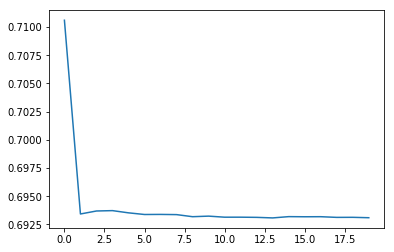

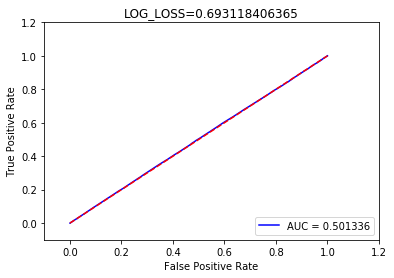

In [24]:
import time
start_time = time.time()    
epochs=200 # change to 1500 for better results
all_losses = []

X_tensor_train= XnumpyToTensor(trainX)
Y_tensor_train= YnumpyToTensor(trainY)

print(type(X_tensor_train.data), type(Y_tensor_train.data)) # should be 'torch.cuda.FloatTensor'

# From here onwards, we must only use PyTorch Tensors
for step in range(epochs):    
    out = net(X_tensor_train)                 # input x and predict based on x
    cost = loss_func(out, Y_tensor_train)     # must be (1. nn output, 2. target), the target label is NOT one-hotted

    optimizer.zero_grad()   # clear gradients for next train
    cost.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
                   
        
    if step % 10 == 0:        
        loss = cost.data[0]
        all_losses.append(loss)
        print(step, cost.data.cpu().numpy())
        # RuntimeError: can't convert CUDA tensor to numpy (it doesn't support GPU arrays). 
        # Use .cpu() to move the tensor to host memory first.        
        prediction = (net(X_tensor_train).data).float() # probabilities         
#         prediction = (net(X_tensor).data > 0.5).float() # zero or one
#         print ("Pred:" + str (prediction)) # Pred:Variable containing: 0 or 1
#         pred_y = prediction.data.numpy().squeeze()            
        pred_y = prediction.cpu().numpy().squeeze()
        target_y = Y_tensor_train.cpu().data.numpy()
                        
        tu = ((pred_y == target_y).mean(),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
        print ('ACC={}, LOG_LOSS={}, ROC_AUC={} '.format(*tu))        
                
end_time = time.time()
print ('{} {:6.3f} seconds'.format('GPU:', end_time-start_time))

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(all_losses)
plt.show()

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#  Performance of the deep learning model on the Validation set

INFO:__main__:Using the CPU
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:24: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
INFO:__main__:Using the CPU


(16686, 21)
(16686,)
(16686, 21)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(16686, 21)
<type 'numpy.ndarray'>
(16686, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'>
(16686, 1)
<type 'numpy.ndarray'>
<class 'torch.FloatTensor'> <class 'torch.FloatTensor'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


acc=0.0 log_loss=0.692716965698 roc_auc=0.524813809759 


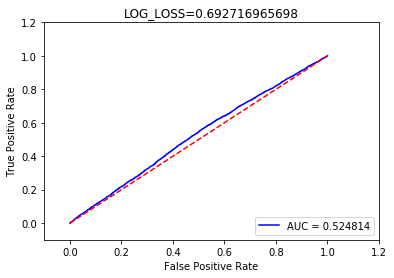

In [17]:
net.eval()
# Validation data
print (valX.shape)
print (valY.shape)

X_tensor_val= XnumpyToTensor(valX)
Y_tensor_val= YnumpyToTensor(valY)


print(type(X_tensor_val.data), type(Y_tensor_val.data)) # should be 'torch.cuda.FloatTensor'

predicted_val = (net(X_tensor_val).data).float() # probabilities 
# predicted_val = (net(X_tensor_val).data > 0.5).float() # zero or one
pred_y = predicted_val.cpu().numpy()
target_y = Y_tensor_val.cpu().data.numpy()                

print (type(pred_y))
print (type(target_y))

tu = (str ((pred_y == target_y).mean()),log_loss(target_y, pred_y),roc_auc_score(target_y,pred_y ))
print ('\n')
print ('acc={} log_loss={} roc_auc={} '.format(*tu))

false_positive_rate, true_positive_rate, thresholds = roc_curve(target_y,pred_y)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LOG_LOSS=' + str(log_loss(target_y, pred_y)))
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.6f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([-0.1, 1.2])
plt.ylim([-0.1, 1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# print (pred_y)

#  Submission on Test set

In [18]:
# testX, df_test_set
# df[df.columns.difference(['b'])]
# trainX, trainY, valX, valY, testX, df_test_set = loadDataSplit()

print (df_test_set.shape)
columns = ['id', 'probability']
df_pred=pd.DataFrame(data=np.zeros((0,len(columns))), columns=columns)
df_pred.id.astype(int)

for index, row in df_test_set.iterrows():
    rwo_no_id=row.drop('id')    
#     print (rwo_no_id.values)    
    x_data_np = np.array(rwo_no_id.values, dtype=np.float32)        
    if use_cuda:
        X_tensor_test = Variable(torch.from_numpy(x_data_np).cuda()) # Note the conversion for pytorch    
    else:
        X_tensor_test = Variable(torch.from_numpy(x_data_np)) # Note the conversion for pytorch
                    
    X_tensor_test=X_tensor_test.view(1, trainX.shape[1]) # does not work with 1d tensors            
    predicted_val = (net(X_tensor_test).data).float() # probabilities     
    p_test =   predicted_val.cpu().numpy().item() # otherwise we get an array, we need a single float
    
    df_pred = df_pred.append({'id':row['id'].astype(int), 'probability':p_test},ignore_index=True)

df_pred.head(5)

(45668, 22)


,id,probability
0,90616.0,0.507826
1,148473.0,0.505317
2,72743.0,0.506913
3,32457.0,0.512687
4,12608.0,0.506489


#  Create a CSV with the ID's and the coresponding probabilities. 

In [19]:
df_pred.id=df_pred.id.astype(int)

def savePred(df_pred, loss):
#     csv_path = 'pred/p_{}_{}_{}.csv'.format(loss, name, (str(time.time())))
    csv_path = 'pred/pred_{}_{}.csv'.format(loss, (str(time.time())))
    df_pred.to_csv(csv_path, columns=('id', 'probability'), index=None)
    print (csv_path)
    
savePred (df_pred, log_loss(target_y, pred_y))

pred/pred_0.692716965698_1505138667.16.csv


#  Actual score on Numer.ai - screenshot of the leader board

<img src="../images/numerai-score.jpg" width="35%" align="center">